In [1]:
from time import time
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from nltk.stem import LancasterStemmer
import matplotlib.pyplot as plt
import pandas as pd

# [ models for classification ]
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


# Prepearing data

In [2]:
def read_data(file_path: str,
              delimiter: str = ",",
              headers: bool = True) -> pd.DataFrame:
    """
    Open .csv file with input data as pandas DataFrame.

    Input:
     * file_path: str
     * delimieter: str = "," - delimiter in csv file
     * headers: bool = True - first row as headers
    
    Ouput:
     * pandas.DataFrame
    """
    if headers:
        return pd.read_csv(file_path, sep=delimiter)
    return pd.read_csv(file_path, sep=delimiter, header=None)


def flat_lists(sentences_list: list[list[str]]) -> list[str]:
    """
    Transform list with list with words to list with words.

    Input:
     * sentences_list: list[list[str]]
    
    Output:
     * list[str]
    
    Example:
        Input:
         * [["Hello", "darknes"], 
            ["my", "old", "friend"]]
        Output:
         * ["Hello", "darknes", "my", "old", "friend"]
    """
    words = []
    for sentence in sentences_list:
        words += sentence
    return words


In [3]:
# [ loading data ]
all_data_frame = read_data("data/Tweets.csv")
print(all_data_frame)


                 tweet_id airline_sentiment  airline_sentiment_confidence  \
0      570306133677760513           neutral                        1.0000   
1      570301130888122368          positive                        0.3486   
2      570301083672813571           neutral                        0.6837   
3      570301031407624196          negative                        1.0000   
4      570300817074462722          negative                        1.0000   
...                   ...               ...                           ...   
14635  569587686496825344          positive                        0.3487   
14636  569587371693355008          negative                        1.0000   
14637  569587242672398336           neutral                        1.0000   
14638  569587188687634433          negative                        1.0000   
14639  569587140490866689           neutral                        0.6771   

               negativereason  negativereason_confidence         airline  \

In [4]:
# [ selecting data ]
airline_sentiment = all_data_frame["airline_sentiment"]

data_frame = pd.DataFrame(
    {"text": all_data_frame["text"]}
    )

print(data_frame)


                                                    text
0                    @VirginAmerica What @dhepburn said.
1      @VirginAmerica plus you've added commercials t...
2      @VirginAmerica I didn't today... Must mean I n...
3      @VirginAmerica it's really aggressive to blast...
4      @VirginAmerica and it's a really big bad thing...
...                                                  ...
14635  @AmericanAir thank you we got on a different f...
14636  @AmericanAir leaving over 20 minutes Late Flig...
14637  @AmericanAir Please bring American Airlines to...
14638  @AmericanAir you have my money, you change my ...
14639  @AmericanAir we have 8 ppl so we need 2 know h...

[14640 rows x 1 columns]


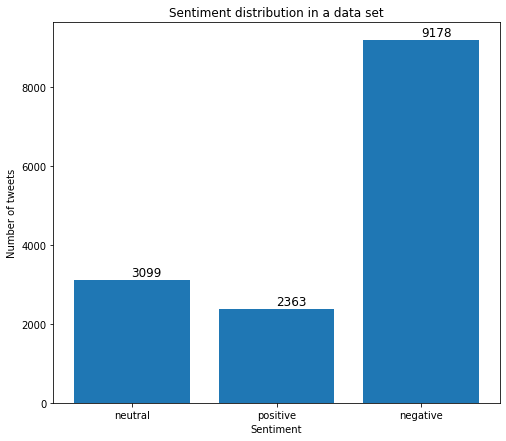

In [5]:
sentiments = {}
for sentiment in airline_sentiment:
    if sentiment not in sentiments:
        sentiments[sentiment] = 1
    else:
        sentiments[sentiment] += 1

plt.figure(figsize=(8, 7))
plt.bar(sentiments.keys(), sentiments.values())
plt.title("Sentiment distribution in a data set")
plt.xlabel("Sentiment")
plt.ylabel("Number of tweets")

for x, y in zip(sentiments.keys(), sentiments.values()):
    plt.text(x, y+100, str(round(y, 2)), color="black", fontsize=12)

plt.show()


In [6]:
def clean_sentence(text: str) -> str:
    """
    Cleaning the sentence from emails, hashtags and web page urls.

    Input:
     * text: str
    
    Output:
     * str
    
    Example:
        Input:
         * "Hello my #BFF, look at this <3 <3 http://virus.net"
        Output:
         * "Hello my BFF look at this"
    """
    text = re.sub("@[A-Za-z0-9]+", "", text)
    text = re.sub("#", "", text)
    text = re.sub(r"https?:\S+", "", text)

    letters = list(" qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM")
    for symbol in text:
        if symbol not in letters:
            text = text.replace(symbol, "")
    return text


def clean_sentences(sentences_list: list[str]) -> list[list[str]]:
    """
    Cleaning sentences from special symbols and tranform it from str to list.
    
    Input:
     * sentences_list: list[str] - list of sentences

    Output:
     * list[list[str]] - list of cleansed sentences (without special symbols)

    Example:
        Input: 
         * ["Hello my World!",
            "How are you?"]
        Output:
             * [["Hello", "my", "World"],
                ["How", "are", "you"]]
    """
    cleansed_sentences = []
    for tweet in [clean_sentence(tweet).split(" ")
                  for tweet in sentences_list]:

        cleansed_sentence = [word.strip() for word in tweet
                             if
                             word != "" and
                             "http" not in word and
                             not word.isdigit()]

        cleansed_sentences.append(cleansed_sentence)

    return cleansed_sentences


In [7]:
# [ data cleaning ]
cleaned_data_frame = pd.DataFrame(
    {"text": clean_sentences(data_frame["text"])}
    )

cleansed_words = flat_lists(cleaned_data_frame["text"])

print(cleaned_data_frame)


                                                    text
0                                           [What, said]
1      [plus, youve, added, commercials, to, the, exp...
2      [I, didnt, today, Must, mean, I, need, to, tak...
3      [its, really, aggressive, to, blast, obnoxious...
4      [and, its, a, really, big, bad, thing, about, it]
...                                                  ...
14635  [thank, you, we, got, on, a, different, flight...
14636  [leaving, over, minutes, Late, Flight, No, war...
14637  [Please, bring, American, Airlines, to, BlackB...
14638  [you, have, my, money, you, change, my, flight...
14639  [we, have, ppl, so, we, need, know, how, many,...

[14640 rows x 1 columns]


In [8]:
def lemmatization_sentence(sentence: list[str],
                           lancaster: LancasterStemmer) -> list[str]:
    """
    Lemmatization of sentence using given lancaster.

    Input:
     * sentence: list[str]
     * lancaster: LancasterStemmer
    
    Output:
     * list[str]
    
    Example:
        Input:
         * ["I", "have", "a", "really", "sweet", "kitty"]
        Output:
         * ["i", "hav", "a", "real", "sweet", "kit"]
    """
    return [lancaster.stem(word) for word in sentence]


def lemmatization_sentences(sentences: list[list[str]],
                            lancaster: LancasterStemmer) -> list[list[str]]:
    """
    Lemmatization list of sentences using given lancaster.

    Input:
     * sentence: list[list[str]]
     * lancaster: LancasterStemmer
    
    Output:     
     * list[str]
    """
    return [lemmatization_sentence(sentence, lancaster) for sentence in sentences]


In [9]:
# [ data lemmatization ]
lancaster = LancasterStemmer()

stemmed_data_frame = pd.DataFrame(
    {"text": lemmatization_sentences(cleaned_data_frame["text"], lancaster)}
    )

print(stemmed_data_frame)


                                                    text
0                                           [what, said]
1       [plu, youv, ad, commerc, to, the, expery, tacky]
2      [i, didnt, today, must, mean, i, nee, to, tak,...
3      [it, real, aggress, to, blast, obnoxy, enterta...
4         [and, it, a, real, big, bad, thing, about, it]
...                                                  ...
14635  [thank, you, we, got, on, a, diff, flight, to,...
14636  [leav, ov, minut, lat, flight, no, warn, or, c...
14637         [pleas, bring, am, airlin, to, blackberry]
14638  [you, hav, my, money, you, chang, my, flight, ...
14639  [we, hav, ppl, so, we, nee, know, how, many, s...

[14640 rows x 1 columns]


In [10]:
# [ creating bag of words ]
stemmed_words = flat_lists(stemmed_data_frame["text"])
bag_of_words = list(set(stemmed_words))

print("Counf of stemmed words:", len(stemmed_words))
print(bag_of_words[:100])


Counf of stemmed words: 233344
['malcom', 'throne', 'gopatriot', 'awhil', 'plu', 'servicelook', 'screens', 'surveyemail', 'muc', 'acarlcom', 'banan', 'pia', 'waitin', 'forev', 'pricew', 'minno', 'bitchy', 'delh', 'havin', 'dee', 'cxp', 'daynot', 'woe', 'onal', 'ho', 'lord', 'cxldprotection', 'phoneon', 'tast', 'delinqu', 'lindsey', 'wop', 'thrown', 'ahhhhh', 'spf', 'nw', 'rang', 'wail', 'helpunitedsuck', 'pleasecomeback', 'bord', 'neverflyusairway', 'unitedairlin', 'iceday', 'strategy', 'billmel', 'aerojobmarket', 'alb', 'agoyet', 'nftyconvention', 'againget', 'waiverskeep', 'gee', 'angstiest', 'tiredampfrust', 'fals', 'mdwfll', 'hourdelay', 'poison', 'minsampput', 'annount', 'bound', 'lasd', 'dissatisfy', 'destin', 'wontflyagainwithyou', 'prank', 'vaileagl', 'lightyear', 'beatz', 'foldup', 'employeefaceless', 'flip', 'mon', 'actua', 'fouryrold', 'did', 'stillwait', 'brrr', 'wantmymoneyback', 'savethoses', 'awrd', 'lifest', 'callguy', 'gary', 'bestinclasssoc', 'bright', 'impressedand',

In [11]:
def sentence_coding(sentence: list[str],
                    bag_of_words: list[str]) -> list[bool]:
    """
    Code the given sentence using given baf of words.

    Input:
     * sentence: list[str]
     * bag_of_words: list[str]
    
    Output:
     * list[bool]
    
    Example:
        Input:
         * ["I", "have", "dog"]
         * ["dog", "cat", "have", "i", "he", "car"]
        Output:
         * [True, False, True, True, False, False]
    """
    return [1 if word in sentence else 0 for word in bag_of_words]


def sentences_coding(sentences: list[list[str]],
                     bag_of_words: list[str]) -> list[bool]:
    """
    Code the given list of sentences using given baf of words.

    Input:
     * sentence: list[list[str]]
     * bag_of_words: list[str]
    
    Output:
     * list[bool]
    """
    return [sentence_coding(sentence, bag_of_words) for sentence in sentences]


In [12]:
# [ change words for numbers ]
coded_data_frame = pd.DataFrame(
   sentences_coding(stemmed_data_frame["text"], bag_of_words)
    )

print(coded_data_frame)


       0     1     2     3     4     5     6     7     8     9     ...  8997  \
0         0     0     0     0     0     0     0     0     0     0  ...     0   
1         0     0     0     0     1     0     0     0     0     0  ...     0   
2         0     0     0     0     0     0     0     0     0     0  ...     0   
3         0     0     0     0     0     0     0     0     0     0  ...     0   
4         0     0     0     0     0     0     0     0     0     0  ...     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
14635     0     0     0     0     0     0     0     0     0     0  ...     0   
14636     0     0     0     0     0     0     0     0     0     0  ...     0   
14637     0     0     0     0     0     0     0     0     0     0  ...     0   
14638     0     0     0     0     0     0     0     0     0     0  ...     0   
14639     0     0     0     0     0     0     0     0     0     0  ...     0   

       8998  8999  9000  9001  9002  90

In [13]:
# [ data normalization by columns (words) ]
scaler = StandardScaler()

normal_data_frame = pd.DataFrame(
    scaler.fit_transform(coded_data_frame)
    )

print(normal_data_frame)


           0         1         2         3          4         5         6     \
0     -0.008265 -0.008265 -0.008265 -0.011689  -0.063611 -0.008265 -0.016532   
1     -0.008265 -0.008265 -0.008265 -0.011689  15.720547 -0.008265 -0.016532   
2     -0.008265 -0.008265 -0.008265 -0.011689  -0.063611 -0.008265 -0.016532   
3     -0.008265 -0.008265 -0.008265 -0.011689  -0.063611 -0.008265 -0.016532   
4     -0.008265 -0.008265 -0.008265 -0.011689  -0.063611 -0.008265 -0.016532   
...         ...       ...       ...       ...        ...       ...       ...   
14635 -0.008265 -0.008265 -0.008265 -0.011689  -0.063611 -0.008265 -0.016532   
14636 -0.008265 -0.008265 -0.008265 -0.011689  -0.063611 -0.008265 -0.016532   
14637 -0.008265 -0.008265 -0.008265 -0.011689  -0.063611 -0.008265 -0.016532   
14638 -0.008265 -0.008265 -0.008265 -0.011689  -0.063611 -0.008265 -0.016532   
14639 -0.008265 -0.008265 -0.008265 -0.011689  -0.063611 -0.008265 -0.016532   

           7         8         9     ..

In [14]:
# [ splitting the data into training data and test data ]
X_train, X_test, y_train, y_test = train_test_split(
    normal_data_frame,
    airline_sentiment,
    test_size=0.2
    )


# MLPClassifier

In [15]:
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(150, 200, 150, 100, 50),
    batch_size=200,
    max_iter=400,
    random_state=1,
    learning_rate_init=0.01)


In [16]:
start = time()
mlp_classifier.fit(X_train, y_train)
mlp_time = time() - start


In [17]:
mlp_y_pred = mlp_classifier.predict(X_test)


In [18]:
print(classification_report(y_test, mlp_y_pred))
mlp_acc = accuracy_score(y_test, mlp_y_pred)


              precision    recall  f1-score   support

    negative       0.82      0.84      0.83      1823
     neutral       0.49      0.50      0.49       631
    positive       0.64      0.57      0.60       474

    accuracy                           0.72      2928
   macro avg       0.65      0.63      0.64      2928
weighted avg       0.72      0.72      0.72      2928



# RandomForestClassifier

In [19]:
rf_classifier = RandomForestClassifier()


In [20]:
start = time()
rf_classifier.fit(X_train, y_train)
rf_time = time() - start


In [21]:
rf_y_pred = rf_classifier.predict(X_test)


In [22]:
print(classification_report(y_test, rf_y_pred))
rf_acc = accuracy_score(y_test, rf_y_pred)


              precision    recall  f1-score   support

    negative       0.76      0.96      0.85      1823
     neutral       0.71      0.40      0.51       631
    positive       0.81      0.46      0.59       474

    accuracy                           0.76      2928
   macro avg       0.76      0.61      0.65      2928
weighted avg       0.76      0.76      0.73      2928



# GaussianNB

In [23]:
gauss_model = GaussianNB()


In [24]:
start = time()
gauss_model.fit(X_train, y_train)
gauss_time = time() - start


In [25]:
gauss_model_y_pred = gauss_model.predict(X_test)


In [26]:
print(classification_report(y_test, gauss_model_y_pred))
gauss_acc = accuracy_score(y_test, gauss_model_y_pred)


              precision    recall  f1-score   support

    negative       0.81      0.37      0.51      1823
     neutral       0.25      0.24      0.25       631
    positive       0.23      0.73      0.35       474

    accuracy                           0.40      2928
   macro avg       0.43      0.45      0.37      2928
weighted avg       0.59      0.40      0.43      2928



# BernoulliNB

In [27]:
bernoulli_model = BernoulliNB()


In [28]:
start = time()
bernoulli_model.fit(X_train, y_train)
bernoulli_time = time() - start


In [29]:
bernoulli_model_y_pred = bernoulli_model.predict(X_test)


In [30]:
print(classification_report(y_test, bernoulli_model_y_pred))
bernoulli_acc = accuracy_score(y_test, bernoulli_model_y_pred)


              precision    recall  f1-score   support

    negative       0.82      0.93      0.87      1823
     neutral       0.64      0.53      0.58       631
    positive       0.77      0.55      0.64       474

    accuracy                           0.78      2928
   macro avg       0.74      0.67      0.70      2928
weighted avg       0.77      0.78      0.77      2928



# LogisticRegression

In [31]:
logreg = LogisticRegression()

start = time()
logreg.fit(X_train, y_train)
logreg_time = time() - start


C:\Users\Jarem\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
logreg_acc = logreg.score(X_test, y_test)

print("Logistic Regression accuracy:", logreg_acc)


Logistic Regression accuracy: 0.6683743169398907


# Plotting

In [33]:
plot_data = {
    "x":      ["Bernoulli", "RF", "MLP", "LogReg", "Gaussian"],
    "y_acc":  [bernoulli_acc,  rf_acc, mlp_acc, logreg_acc, gauss_acc],
    "y_time": [bernoulli_time, rf_time, mlp_time, logreg_time, gauss_time]
}


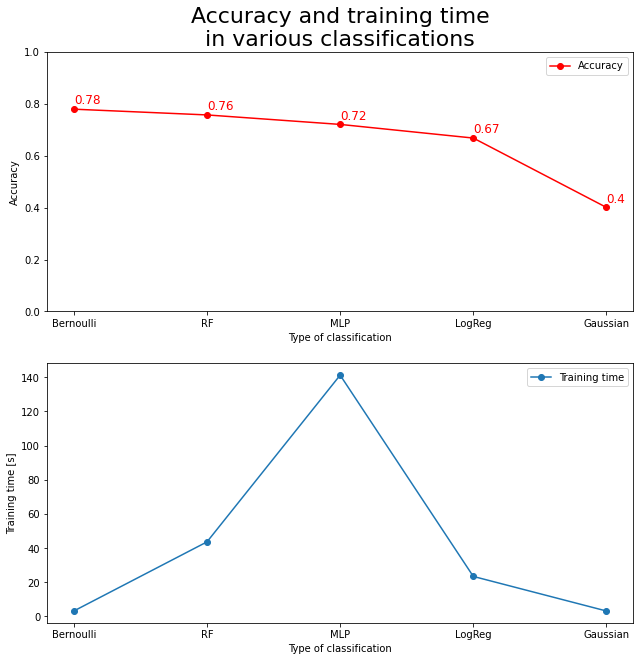

In [34]:
fig, axs = plt.subplots(2)
fig.set_size_inches(10.5, 10.5)
axs[0].set_title("Accuracy and training time\nin various classifications", fontsize=22)

axs[0].plot(plot_data["x"], plot_data["y_acc"], "-o", color="red", label="Accuracy")
axs[0].set_ylim([0.0, 1.0])

for x, y in zip(plot_data["x"], plot_data["y_acc"]):
    axs[0].text(x, y+0.02, str(round(y, 2)), color="red", fontsize=12)

axs[0].legend(loc=0)
axs[0].set_xlabel("Type of classification")
axs[0].set_ylabel("Accuracy")

axs[1].plot(plot_data["x"], plot_data["y_time"], "-o", label="Training time")
axs[1].legend(loc=0)
axs[1].set_xlabel("Type of classification")
axs[1].set_ylabel("Training time [s]")

plt.show()
